# Bitcoin Trading Agent - Complete Notebook

This notebook provides a comprehensive overview of the Bitcoin Trading Agent project and allows you to test each component step by step.

## Project Overview

The Bitcoin Trading Agent is a smart, ML-enhanced Bitcoin trading system that combines:
- **Dollar-Cost Averaging (DCA)** with configurable thresholds
- **ML-Enhanced Swing Trading** using ARIMA forecasting
- **Dynamic Risk Management** with ATR-based stops
- **24/7 Automated Operation** with notifications

## Architecture
```
src/
├── config/           # Configuration management
├── data/            # Price data fetching (Coinbase API)
├── strategy/        # DCA + Hybrid strategy logic
├── broker/          # Paper trading execution
├── ml/              # ARIMA forecasting + threshold adaptation
├── notify/          # Telegram + Gmail notifications
├── backtest/        # Strategy validation engine
├── scheduler.py     # 24/7 job orchestration
└── main.py          # Main trading loop
```

## Main Trading Loop Workflow

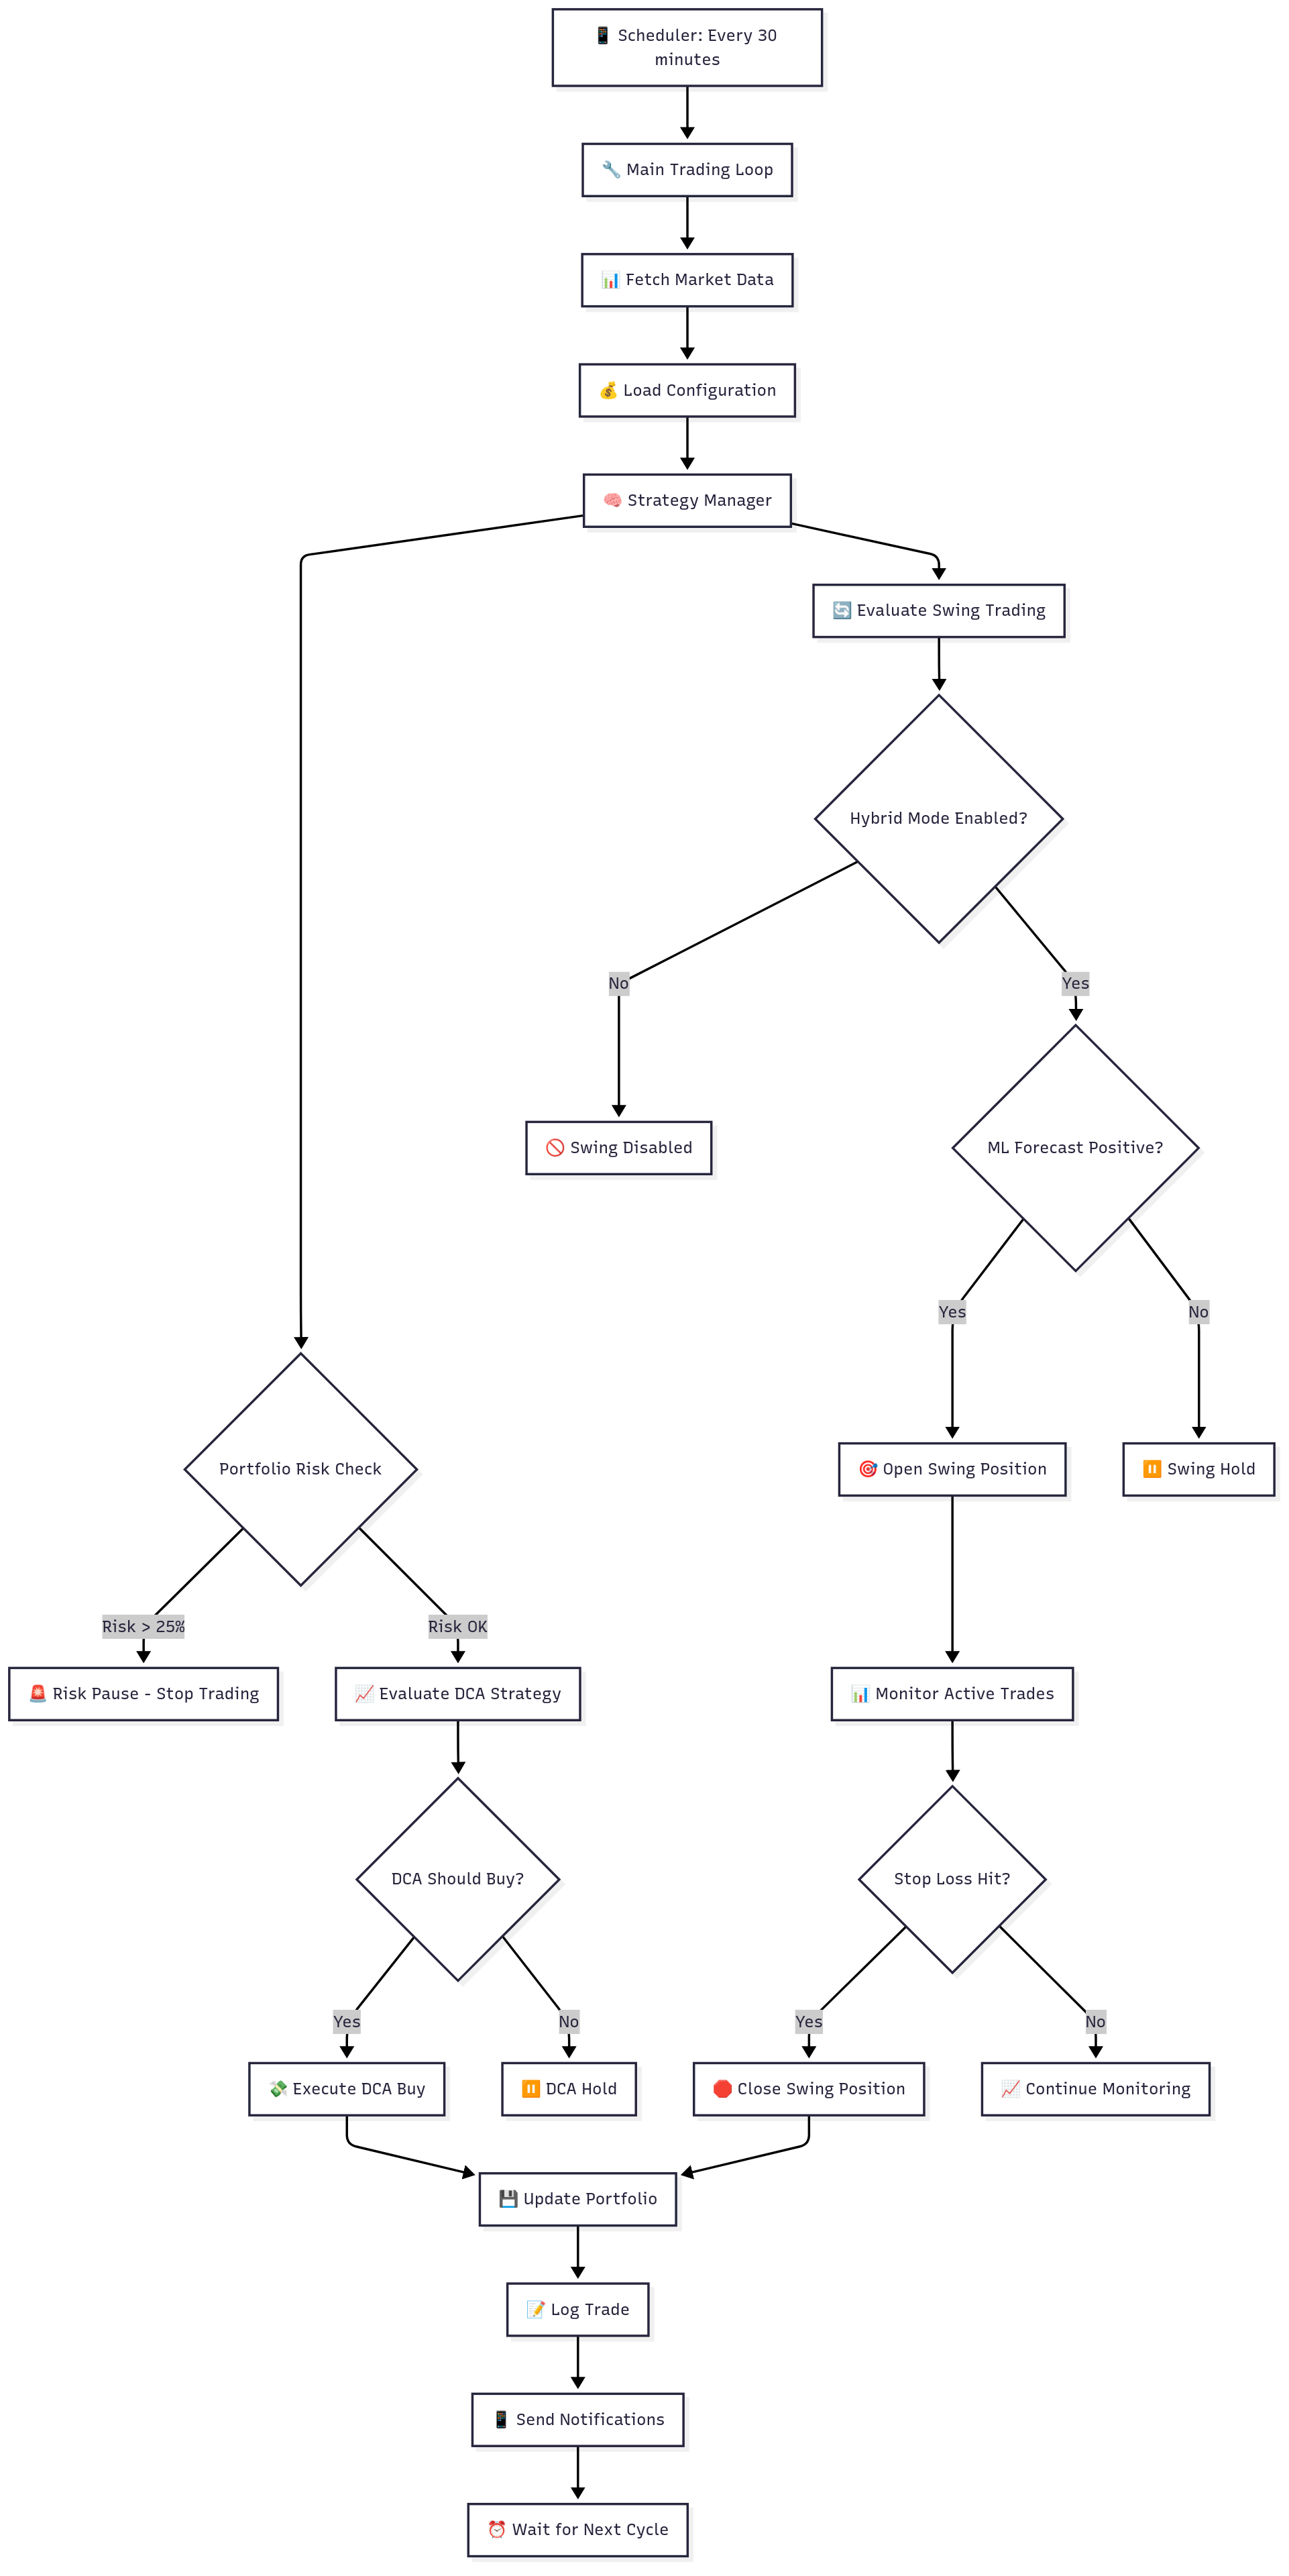

In [43]:
from IPython.display import Image, display

display(Image('Main Trading Loop Workflow.png', width=900))

## 1. Setup and Dependencies

First, let's install the required packages and set up the environment.

In [1]:
# Install required packages
!pip install python-dotenv pydantic requests pandas numpy yfinance python-telegram-bot gspread google-auth APScheduler statsmodels

In [2]:
# Import all required libraries
import sys
import os
import json
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pathlib import Path
import warnings
import requests
warnings.filterwarnings('ignore')

# Add src directory to path
sys.path.append('src')

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## 2. Data Module Testing

Let's look at the price_data functions and test the price data fetching functionality.

#### 2.1 Fetch Bitcoin Data (src/data/price_data.py)

In [3]:
# fetch_bitcoin_data
def fetch_bitcoin_data(symbol="BTC-USD", period="30d", interval="30m"):
    """Fetch Bitcoin data from Coinbase Exchange API."""
    try:
        # Get current Bitcoin price from Coinbase
        current_url = "https://api.coinbase.com/v2/prices/BTC-USD/spot"
        current_response = requests.get(current_url, timeout=10)
        
        if current_response.status_code != 200:
            print(f"❌ Current price: HTTP {current_response.status_code}")
            return pd.DataFrame()
        
        current_data = current_response.json()
        current_price = float(current_data['data']['amount'])
        
        # Get historical data from Coinbase Exchange API
        # Calculate date range for historical data
        end_time = datetime.now()
        start_time = end_time - timedelta(days=30)
        
        # Convert to date format for the API
        start_date = start_time.strftime('%Y-%m-%d')
        end_date = end_time.strftime('%Y-%m-%d')
        
        # Use the Coinbase Exchange API endpoint (no authentication required)
        # Granularity: 86400 = 1 day, 3600 = 1 hour, 300 = 5 minutes
        historical_url = f"https://api.exchange.coinbase.com/products/BTC-USD/candles?start={start_date}&end={end_date}&granularity=86400"
        
        # Make the request directly
        historical_response = requests.get(historical_url, timeout=10)
        
        if historical_response.status_code == 200:
            candles = historical_response.json()
            
            if candles and isinstance(candles, list) and len(candles) > 0:
                # Vectorized processing: [time, low, high, open, close, volume]
                columns = ['time', 'Low', 'High', 'Open', 'Close', 'Volume']
                filtered = [c for c in candles if isinstance(c, (list, tuple)) and len(c) == 6]

                if filtered:
                    df = pd.DataFrame(filtered, columns=columns)
                    df['time'] = pd.to_datetime(df['time'], unit='s', utc=True)
                    numeric_cols = ['Low', 'High', 'Open', 'Close', 'Volume']
                    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
                    df = df.dropna(subset=numeric_cols)
                    df.set_index('time', inplace=True)
                    return df
        
        print("❌ Failed to fetch historical data")
        return pd.DataFrame()
        
    except Exception as e:
        print(f"❌ Data fetch error: {e}")
        return pd.DataFrame()

#### 2.2 Calculate ATR (src/data/price_data.py)

In [4]:
# calculate_atr
def calculate_atr(data, period=14):
    """Calculate Average True Range (ATR) indicator."""
    if data.empty or len(data) < period:
        print(f"❌ Need at least {period} data points for ATR")
        return pd.Series()
    
    try:
        # Calculate True Range
        high_low = data['High'] - data['Low']
        high_close = abs(data['High'] - data['Close'].shift())
        low_close = abs(data['Low'] - data['Close'].shift())
        
        true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
        atr = true_range.rolling(window=period).mean()
        
        return atr
        
    except Exception as e:
        print(f"❌ ATR calculation failed: {e}")
        return pd.Series()

#### 2.3 Get latest price and ATR (src/data/price_data.py)

In [5]:
# get_latest_price_and_atr  
def get_latest_price_and_atr(symbol="BTC-USD"):
    """Get latest Bitcoin price and ATR - main function called every 30 minutes."""
    data = fetch_bitcoin_data(symbol, period="30d", interval="30m")
    
    if data.empty:
        return {"error": "No data available"}
    
    atr = calculate_atr(data)
    if atr.empty:
        return {"error": "ATR calculation failed"}
    
    latest_price = data['Close'].iloc[-1]
    latest_atr = atr.iloc[-1]
    
    # Calculate price change
    if len(data) > 1:
        price_change = ((latest_price - data['Close'].iloc[-2]) / data['Close'].iloc[-2]) * 100
    else:
        price_change = 0.0
    
    result = {
        "timestamp": datetime.now().isoformat(),
        "price": latest_price,
        "price_change_percent": price_change,
        "atr": latest_atr,
        "volume": data['Volume'].iloc[-1] if 'Volume' in data.columns else 0,
        "high": data['High'].iloc[-1],
        "low": data['Low'].iloc[-1]
    }
    
    print(f"📊 Market: ${latest_price:,.2f} ({price_change:+.2f}%) | ATR: ${latest_atr:,.2f}")
    return result

#### 2.4 Test Bitcoin data fetching

In [6]:
# Test Bitcoin data fetching

print("🔍 Testing Bitcoin data fetching...")

# Fetch historical data
df = fetch_bitcoin_data()
print(f"\n📊 Historical data shape: {df.shape}")
print(f"📅 Date range: {df.index[0]} to {df.index[-1]}")
print(f"💰 Price range: ${df['Close'].min():,.2f} - ${df['Close'].max():,.2f}")

# Display first few rows
df.head()

🔍 Testing Bitcoin data fetching...

📊 Historical data shape: (31, 5)
📅 Date range: 2025-08-25 00:00:00+00:00 to 2025-07-26 00:00:00+00:00
💰 Price range: $112,042.98 - $123,365.63


,Low,High,Open,Close,Volume
time,,,,,
2025-08-25 00:00:00+00:00,110555.26,113645.32,113478.00,112042.98,5500.927493
2025-08-24 00:00:00+00:00,110635.00,115616.53,115383.87,113478.00,4602.763225
2025-08-23 00:00:00+00:00,114505.00,116999.03,116911.90,115383.87,2245.419253
2025-08-22 00:00:00+00:00,111649.75,117416.73,112480.29,116908.68,8547.720891
2025-08-21 00:00:00+00:00,111964.00,114812.00,114276.00,112480.30,6033.744354


#### 2.5 Test ATR calculation

📈 Testing ATR calculation...
ATR series length: 31
Latest ATR: $2,886.30


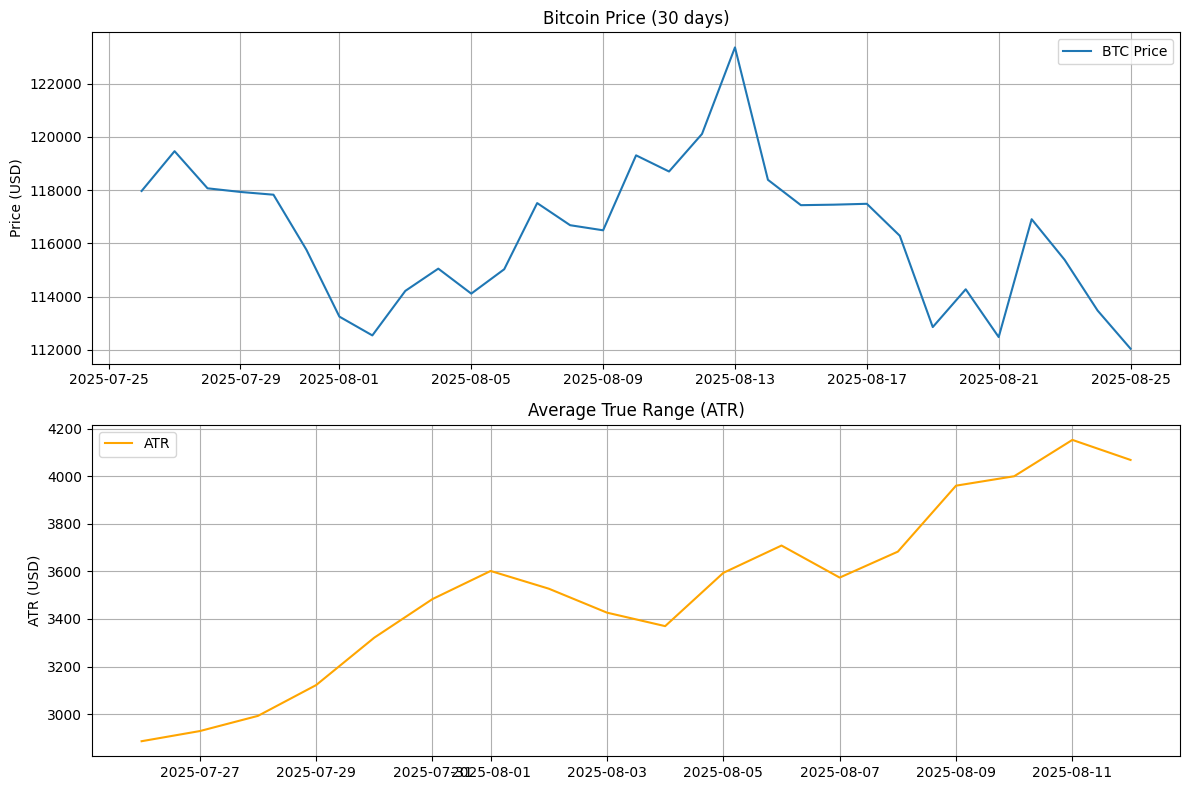

In [7]:
# Test ATR calculation
print("📈 Testing ATR calculation...")

atr_series = calculate_atr(df)
print(f"ATR series length: {len(atr_series)}")
print(f"Latest ATR: ${atr_series.iloc[-1]:,.2f}")

# Add ATR to dataframe
df['ATR'] = atr_series

# Plot price and ATR
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
ax1.plot(df.index, df['Close'], label='BTC Price')
ax1.set_title('Bitcoin Price (30 days)')
ax1.set_ylabel('Price (USD)')
ax1.legend()
ax1.grid(True)

ax2.plot(df.index, df['ATR'], label='ATR', color='orange')
ax2.set_title('Average True Range (ATR)')
ax2.set_ylabel('ATR (USD)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## 3. DCA Strategy Testing

Let's build and test the Dollar-Cost Averaging strategy component.

### Class DCAStrategy with the following functions: (src/strategy/dca_strategy.py)
- **should_buy** (Evaluates whether to buy based on price drop percentage, time intervals, and budget constraints)
- **execute_buy** (Executes a buy order, records the purchase, and updates portfolio tracking variables)
- **get_portfolio_summary** (Returns current portfolio status including BTC holdings, total spent, current value, and P&L calculations)
- **get_purchase_history** (Returns a copy of all recorded purchase transactions for analysis and tracking)

In [8]:
class DCAStrategy:
    """
    Simple Dollar-Cost Averaging strategy for Bitcoin.
    Buys when price drops by a specified percentage.
    """
    
    def __init__(self, budget_usd, dca_amount_usd, drop_percent, min_interval_hours=24):
        """
        Initialize DCA strategy.
        
        Args:
            budget_usd (float): Total budget available
            dca_amount_usd (float): Amount to buy each time
            drop_percent (float): Price drop percentage to trigger buy
            min_interval_hours (int): Minimum hours between buys
        """
        self.budget_usd = budget_usd
        self.dca_amount_usd = dca_amount_usd
        self.drop_percent = drop_percent
        self.min_interval_hours = min_interval_hours
        
        # Track purchases
        self.purchases = []
        self.last_purchase_time = None
        self.total_spent = 0.0
        self.total_btc = 0.0
        
        print(f"💰 DCA Strategy initialized:")
        print(f"   Budget: ${budget_usd:,.2f}")
        print(f"   DCA Amount: ${dca_amount_usd:,.2f}")
        print(f"   Drop Trigger: {drop_percent}%")
        print(f"   Min Interval: {min_interval_hours} hours")
    
    # 3.1 Should buy
    
    def should_buy(self, current_price, previous_price, current_time):
        """
        Check if we should buy based on DCA rules.
        
        Args:
            current_price (float): Current Bitcoin price
            previous_price (float): Previous Bitcoin price
            current_time (datetime): Current time
            
        Returns:
            dict: Buy decision and details
        """
        # Calculate price drop percentage
        if previous_price <= 0:
            return {"should_buy": False, "reason": "No previous price data"}
        
        price_drop = ((previous_price - current_price) / previous_price) * 100
        
        # Check if enough time has passed since last purchase
        time_since_last = None
        if self.last_purchase_time:
            time_since_last = (current_time - self.last_purchase_time).total_seconds() / 3600
        
        # Check if we have enough budget
        if self.total_spent + self.dca_amount_usd > self.budget_usd:
            return {"should_buy": False, "reason": "Insufficient budget"}
        
        # Check time interval
        if time_since_last and time_since_last < self.min_interval_hours:
            return {"should_buy": False, "reason": f"Too soon since last purchase ({time_since_last:.1f}h < {self.min_interval_hours}h)"}
        
        # Check if price drop meets threshold
        if price_drop >= self.drop_percent:
            return {
                "should_buy": True,
                "reason": f"Price dropped {price_drop:.2f}% (threshold: {self.drop_percent}%)",
                "price_drop": price_drop,
                "amount_usd": self.dca_amount_usd
            }
        
        return {"should_buy": False, "reason": f"Price drop {price_drop:.2f}% below threshold {self.drop_percent}%"}
    
    # 3.2 Execute buy
    
    def execute_buy(self, price_usd, amount_usd, timestamp):
        """
        Execute a buy order and record it.
        
        Args:
            price_usd (float): Price per Bitcoin
            amount_usd (float): Amount spent in USD
            timestamp (datetime): When the buy happened
        """
        btc_amount = amount_usd / price_usd
        
        purchase = {
            "timestamp": timestamp,
            "price_usd": price_usd,
            "amount_usd": amount_usd,
            "btc_amount": btc_amount,
            "type": "DCA"
        }
        
        self.purchases.append(purchase)
        self.last_purchase_time = timestamp
        self.total_spent += amount_usd
        self.total_btc += btc_amount
        
        print(f"✅ DCA Buy executed:")
        print(f"   Price: ${price_usd:,.2f}")
        print(f"   Amount: ${amount_usd:,.2f}")
        print(f"   BTC: {btc_amount:.8f}")
        print(f"   Total spent: ${self.total_spent:,.2f}")
        print(f"   Total BTC: {self.total_btc:.8f}")

    # 3.3 Get portfolio summary
    
    def get_portfolio_summary(self, current_price):
        """
        Get current portfolio summary.
        
        Args:
            current_price (float): Current Bitcoin price
            
        Returns:
            dict: Portfolio summary
        """
        if self.total_btc == 0:
            return {
                "total_btc": 0,
                "total_spent": 0,
                "current_value": 0,
                "unrealized_pnl": 0,
                "unrealized_pnl_percent": 0
            }
        
        current_value = self.total_btc * current_price
        unrealized_pnl = current_value - self.total_spent
        unrealized_pnl_percent = (unrealized_pnl / self.total_spent) * 100
        
        return {
            "total_btc": self.total_btc,
            "total_spent": self.total_spent,
            "current_value": current_value,
            "unrealized_pnl": unrealized_pnl,
            "unrealized_pnl_percent": unrealized_pnl_percent,
            "average_price": self.total_spent / self.total_btc
        }
    
    # 3.4 Get purchase history
    
    def get_purchase_history(self):
        """Get list of all purchases."""
        return self.purchases.copy()

#### 3.5 Test DCA Strategy

In [9]:
# Test DCA Strategy
print("💰 Testing DCA Strategy...")

# Initialize DCA strategy
dca = DCAStrategy(
    budget_usd=10000,
    dca_amount_usd=500,
    drop_percent=3.0,
    min_interval_hours=24
)

print("\n📋 DCA Strategy initialized successfully!")
print(f"Budget: ${dca.budget_usd:,.2f}")
print(f"DCA Amount: ${dca.dca_amount_usd:,.2f}")
print(f"Drop Trigger: {dca.drop_percent}%")
print(f"Min Interval: {dca.min_interval_hours} hours")

💰 Testing DCA Strategy...
💰 DCA Strategy initialized:
   Budget: $10,000.00
   DCA Amount: $500.00
   Drop Trigger: 3.0%
   Min Interval: 24 hours

📋 DCA Strategy initialized successfully!
Budget: $10,000.00
DCA Amount: $500.00
Drop Trigger: 3.0%
Min Interval: 24 hours


#### 3.6 Test DCA decision logic

In [10]:
# Test DCA decision logic
print("🤔 Testing DCA decision logic...")

# Get current price
current_price = float(df['Close'].iloc[-1])
previous_price = float(df['Close'].iloc[-2])
current_time = datetime.now()

print(f"Current Price: ${current_price:,.2f}")
print(f"Previous Price: ${previous_price:,.2f}")
print(f"Price Change: {((current_price - previous_price) / previous_price) * 100:+.2f}%")

# Test DCA decision
decision = dca.should_buy(current_price, previous_price, current_time)
print(f"\n📊 DCA Decision:")
for key, value in decision.items():
    print(f"  {key}: {value}")

🤔 Testing DCA decision logic...
Current Price: $117,969.63
Previous Price: $119,465.52
Price Change: -1.25%

📊 DCA Decision:
  should_buy: False
  reason: Price drop 1.25% below threshold 3.0%


## 4. ML Forecasting Testing

Let's build and test the ARIMA forecasting functionality.

#### 4.0 Forecasting model training and selection (src/ml/grid_search_cv.py)

In [11]:
import json
import warnings
from pathlib import Path

import numpy as np

from src.data.price_data import fetch_bitcoin_data
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA


def _mae(preds, actuals):
	mask = ~np.isnan(preds)
	if not mask.any():
		return float("nan")
	return float(np.mean(np.abs(preds[mask] - actuals[mask])))



def _walk_forward(close, train_len, test_len, fit_fn):
	y = close.astype(float).dropna()
	if len(y) < train_len + test_len:
		return float("nan"), 0
	start = len(y) - test_len
	preds = []
	actuals = []
	with warnings.catch_warnings():
		warnings.simplefilter("ignore")
		for i in range(start, len(y)):
			train = y[i - train_len:i]
			actuals.append(float(y.iloc[i]))
			try:
				pred = fit_fn(train)
			except Exception:
				pred = np.nan
			preds.append(pred)
	actuals = np.array(actuals, dtype=float)
	preds = np.array(preds, dtype=float)
	return _mae(preds, actuals), int(np.sum(~np.isnan(preds)))


def grid_search_cv(close, train_len=60, test_len=14):
	results = {"ES": {}, "AR": {}, "ARIMA": {}}

	# ES(add) with/without damping
	for damped in (False, True):
		def fit_es(train, _damped=damped):
			m = ExponentialSmoothing(train, trend="add", seasonal=None, damped_trend=_damped).fit(optimized=True)
			return float(m.forecast(1).iloc[0])
		mae, n = _walk_forward(close, train_len, test_len, fit_es)
		results["ES"][f"add_damped={damped}"] = {"MAE": mae, "n": n}

	# AR with different lags
	for lags in (3, 5, 7, 10):
		def fit_ar(train, _lags=lags):
			m = AutoReg(train, lags=_lags, old_names=False).fit()
			return float(m.forecast(1).iloc[0])
		mae, n = _walk_forward(close, train_len, test_len, fit_ar)
		results["AR"][f"lags={lags}"] = {"MAE": mae, "n": n}

	# ARIMA grid (tiny)
	for p in (0, 1, 2):
		for q in (0, 1, 2):
			def fit_arima(train, _p=p, _q=q):
				m = ARIMA(train, order=(_p, 1, _q)).fit()
				return float(m.forecast(1).iloc[0])
			mae, n = _walk_forward(close, train_len, test_len, fit_arima)
			results["ARIMA"][f"({p},1,{q})"] = {"MAE": mae, "n": n}

	# Pick best per family
	summary = {"details": results, "best": {}}
	for family, cfgs in results.items():
		best_cfg = None
		best_mae = float("inf")
		for name, val in cfgs.items():
			mae = val["MAE"]
			if mae == mae and mae < best_mae:  # check not NaN and better
				best_mae = mae
				best_cfg = name
		summary["best"][family] = {"config": best_cfg, "MAE": best_mae}
	return summary


def main():
	df = fetch_bitcoin_data(period="60d")
	if df.empty or "Close" not in df.columns:
		print("No data available for grid search.")
		return
	res = grid_search_cv(df["Close"], train_len=20, test_len=7)
	print("Grid search summary:")
	print(json.dumps(res["best"], indent=2))
	Path("data").mkdir(parents=True, exist_ok=True)
	with Path("data/grid_search_cv_results.json").open("w", encoding="utf-8") as f:
		json.dump(res, f, indent=2)


if __name__ == "__main__":
	main()


Grid search summary:
{
  "ES": {
    "config": "add_damped=True",
    "MAE": 1489.237390717342
  },
  "AR": {
    "config": "lags=5",
    "MAE": 1137.9325855623154
  },
  "ARIMA": {
    "config": "(1,1,0)",
    "MAE": 1193.495808856225
  }
}


The Final test results are saved in "data/grid_search_cv_results.json"

#### 4.1 Forecast next (src/ml/forecasting.py)

In [12]:
def forecast_next(candles_df):
	"""Forecast next close using ARIMA(1,1,2) only.

	Returns (pred_return, pred_strength) where pred_return is fractional return.
	Falls back to neutral (0, 0) if not enough data or model fails.
	"""
	try:
		if candles_df is None or candles_df.empty or "Close" not in candles_df.columns:
			return 0.0, 0.0
		series = candles_df["Close"].astype(float).tail(300)
		if len(series) < 20:
			return 0.0, 0.0

		with warnings.catch_warnings():
			warnings.simplefilter("ignore")
			model = ARIMA(series, order=(1, 1, 2)).fit()
			yhat = float(model.forecast(1).iloc[0])
		last = float(series.iloc[-1])
		if last <= 0:
			return 0.0, 0.0

		pred_return = (yhat - last) / last
		# Strength = size of predicted move relative to 1% (clipped to [0,1])
		pred_strength = max(0.0, min(1.0, abs(pred_return) / 0.01))

		return float(pred_return), float(pred_strength)
	except Exception:
		return 0.0, 0.0

#### 4.2 Test ML Forecasting

In [13]:
# Test ML Forecasting
print("🧠 Testing ML Forecasting...")

# Test forecast
pred_return, pred_strength = forecast_next(df)
print(f"\n📊 Forecast Results:")
print(f"Predicted Return: {pred_return:+.4f} ({pred_return*100:+.2f}%)")
print(f"Prediction Strength: {pred_strength:.4f}")

# Interpret forecast
if pred_return > 0:
    print("📈 Bullish forecast: Price expected to rise")
elif pred_return < 0:
    print("📉 Bearish forecast: Price expected to fall")
else:
    print("➡️ Neutral forecast: No clear direction")

if pred_strength > 0.5:
    print("💪 Strong prediction confidence")
elif pred_strength > 0.2:
    print("👍 Moderate prediction confidence")
else:
    print("🤷 Weak prediction confidence")

🧠 Testing ML Forecasting...

📊 Forecast Results:
Predicted Return: -0.0002 (-0.02%)
Prediction Strength: 0.0223
📉 Bearish forecast: Price expected to fall
🤷 Weak prediction confidence


## 5. Threshold Adaptation Testing

Let's test the ML-driven threshold adaptation system.

#### 5.1 Adapt Thresholds (src/ml/threshold_adapter.py)

In [14]:
RUNTIME_OVERRIDES = Path("data/runtime_overrides.json")


def _clamp(value, lo, hi):
	return max(lo, min(hi, value))


def adapt_thresholds(base_cfg, pred_return, pred_strength, atr_value):
	"""Map forecast to simple runtime overrides for hybrid mode.

	- Tighten ATR k slightly if positive expectation; loosen if negative.
	- Nudge DCA drop percent inversely to expectation.
	"""
	base_k = float(base_cfg.get("ATR_MULTIPLIER", 1.5))
	base_drop = float(base_cfg.get("DCA_DROP_PERCENT", 3.0))

	# Example mapping: +/- 0.5 on k within [1.0, 2.5]
	k = base_k - pred_return * 5.0  # +ret → smaller k (tighter); -ret → larger k
	k = _clamp(k, 1.0, 2.5)

	# Nudge DCA drop by up to +/- 1.0pp based on expectation
	drop = base_drop + (-pred_return * 100.0) * 0.3
	drop = _clamp(drop, 1.0, 8.0)

	enable_swing = pred_return > 0 and pred_strength > 0.2

	return {
		"enable_swing": bool(enable_swing),
		"atr_k_stop": round(k, 2),
		"dca_drop_percent": round(drop, 2),
	}

#### 5.2 Write and Read Overrides (src/ml/threshold_adapter.py)

In [15]:
def write_overrides(payload):
	RUNTIME_OVERRIDES.parent.mkdir(parents=True, exist_ok=True)
	with RUNTIME_OVERRIDES.open("w", encoding="utf-8") as f:
		json.dump(payload, f, indent=2)


def read_overrides():
	if not RUNTIME_OVERRIDES.exists():
		return {}
	try:
		with RUNTIME_OVERRIDES.open("r", encoding="utf-8") as f:
			return json.load(f)
	except Exception:
		return {}

#### 5.3 Test Threshold Adaptation

In [16]:
# Test Threshold Adaptation
from ml.threshold_adapter import adapt_thresholds, write_overrides, read_overrides

print("⚙️ Testing Threshold Adaptation...")

# Base configuration
base_config = {
    "ATR_MULTIPLIER": 1.5,
    "DCA_DROP_PERCENT": 3.0
}

print(f"\n📋 Base Configuration:")
for key, value in base_config.items():
    print(f"  {key}: {value}")

# Test adaptation with our forecast
adapted = adapt_thresholds(base_config, pred_return, pred_strength, df['ATR'].iloc[-1])
print(f"\n🔄 Adapted Thresholds:")
for key, value in adapted.items():
    print(f"  {key}: {value}")

# Write overrides to file
write_overrides(adapted)
print("\n💾 Overrides saved to file")

⚙️ Testing Threshold Adaptation...

📋 Base Configuration:
  ATR_MULTIPLIER: 1.5
  DCA_DROP_PERCENT: 3.0

🔄 Adapted Thresholds:
  enable_swing: False
  atr_k_stop: 1.5
  dca_drop_percent: 3.01

💾 Overrides saved to file


#### 5.3 Test reading overrides

In [17]:
# Test reading overrides
print("📖 Testing override reading...")

overrides = read_overrides()
print(f"\n📋 Current Overrides:")
for key, value in overrides.items():
    print(f"  {key}: {value}")

📖 Testing override reading...

📋 Current Overrides:
  enable_swing: False
  atr_k_stop: 1.5
  dca_drop_percent: 3.01


## 6. Paper Broker Testing

Let's build and test the paper trading execution system.

#### 6.1 Set Initial Cash & Get Position (src/broker/paper_broker.py)

In [18]:
DATA_DIR = Path("data")
TRADES_CSV = DATA_DIR / "trades.csv"
PORTFOLIO_JSON = DATA_DIR / "portfolio.json"


def _ensure_storage():
	DATA_DIR.mkdir(parents=True, exist_ok=True)
	if not TRADES_CSV.exists():
		TRADES_CSV.write_text("timestamp,type,price_usd,amount_usd,btc_amount,notes\n", encoding="utf-8")
	if not PORTFOLIO_JSON.exists():
		PORTFOLIO_JSON.write_text(json.dumps({"cash_usd": 0.0, "btc": 0.0, "initial_cash": 0.0}, indent=2), encoding="utf-8")


def _read_portfolio():
	_ensure_storage()
	with PORTFOLIO_JSON.open("r", encoding="utf-8") as f:
		return json.load(f)


def _write_portfolio(state):
	with PORTFOLIO_JSON.open("w", encoding="utf-8") as f:
		json.dump(state, f, indent=2)


def set_initial_cash(budget_usd):
	state = _read_portfolio()
	current_cash = float(state.get("cash_usd", 0.0))
	current_btc = float(state.get("btc", 0.0))
	# Initialize only if portfolio is fresh
	if current_cash == 0.0 and current_btc == 0.0:
		state["cash_usd"] = float(budget_usd)
		state["initial_cash"] = float(budget_usd)  # Track initial cash for risk calculations
		_write_portfolio(state)

# Get position
                         
def get_position():
	state = _read_portfolio()
	return {"cash_usd": float(state.get("cash_usd", 0.0)), "btc": float(state.get("btc", 0.0))}

#### 6.2 Place Market Buy and Sell (src/broker/paper_broker.py)

In [19]:
def place_market_buy(price_usd, amount_usd, note="DCA"):
	_ensure_storage()
	state = _read_portfolio()
	if amount_usd > state.get("cash_usd", 0.0):
		raise ValueError("Insufficient cash for buy")
	btc_amount = amount_usd / price_usd if price_usd > 0 else 0.0
	state["cash_usd"] = float(state.get("cash_usd", 0.0)) - float(amount_usd)
	state["btc"] = float(state.get("btc", 0.0)) + float(btc_amount)
	_write_portfolio(state)
	with TRADES_CSV.open("a", encoding="utf-8") as f:
		f.write(f"{datetime.now().isoformat()},BUY,{price_usd:.2f},{amount_usd:.2f},{btc_amount:.8f},{note}\n")
	return {"price_usd": price_usd, "amount_usd": amount_usd, "btc_amount": btc_amount}


def place_market_sell(price_usd, btc_amount, note="SELL"):
	_ensure_storage()
	state = _read_portfolio()
	if btc_amount > state.get("btc", 0.0):
		raise ValueError("Insufficient BTC for sell")
	amount_usd = btc_amount * price_usd
	state["cash_usd"] = float(state.get("cash_usd", 0.0)) + float(amount_usd)
	state["btc"] = float(state.get("btc", 0.0)) - float(btc_amount)
	_write_portfolio(state)
	with TRADES_CSV.open("a", encoding="utf-8") as f:
		f.write(f"{datetime.now().isoformat()},SELL,{price_usd:.2f},{amount_usd:.2f},{btc_amount:.8f},{note}\n")
	return {"price_usd": price_usd, "amount_usd": amount_usd, "btc_amount": btc_amount}

#### 6.3 Test Set Initial Cash & Get Position

In [20]:
# Test Paper Broker
print("🏦 Testing Paper Broker...")

# Initialize portfolio with $10,000
set_initial_cash(10000)
print("💰 Portfolio initialized with $10,000")

# Get current position
position = get_position()
print(f"\n📊 Current Position:")
print(f"  Cash: ${position['cash_usd']:,.2f}")
print(f"  BTC: {position['btc']:.8f}")

🏦 Testing Paper Broker...
💰 Portfolio initialized with $10,000

📊 Current Position:
  Cash: $9,000.00
  BTC: 0.00847676


#### 6.4 Test Market Buy

In [21]:
# Test market buy
print("🛒 Testing market buy...")

try:
    buy_result = place_market_buy(
        price_usd=current_price,
        amount_usd=500,
        note="Test DCA Buy"
    )
    
    print(f"\n✅ Buy executed successfully:")
    print(f"  Price: ${buy_result['price_usd']:,.2f}")
    print(f"  Amount: ${buy_result['amount_usd']:,.2f}")
    print(f"  BTC: {buy_result['btc_amount']:.8f}")
    
    # Check updated position
    new_position = get_position()
    print(f"\n📊 Updated Position:")
    print(f"  Cash: ${new_position['cash_usd']:,.2f}")
    print(f"  BTC: {new_position['btc']:.8f}")
    
except Exception as e:
    print(f"❌ Buy failed: {e}")

🛒 Testing market buy...

✅ Buy executed successfully:
  Price: $117,969.63
  Amount: $500.00
  BTC: 0.00423838

📊 Updated Position:
  Cash: $8,500.00
  BTC: 0.01271514


## 7. Strategy Manager Testing

Let's build and test the main strategy orchestration system.

### class StrategyManager with the following functions: (src/strategy/strategy_manager.py)
- **_load_active_trades** (Loads the list of currently open swing trades from the JSON file)
- **_save_active_trades** (Saves the updated list of active swing trades to the JSON file)
- **_check_portfolio_risk** (Checks if portfolio drawdown exceeds the maximum threshold and returns risk status)
- **step** (Evaluates DCA strategy for a single price point and returns buy/hold decision)
- **evaluate_hybrid** (Main function that evaluates both DCA and swing trading decisions together, including risk checks)
- **record_swing_open** (Marks a new swing trade as "open" and saves it to the active trades list)
- **record_swing_close** (Removes a closed swing trade from the active trades storage)

In [22]:
from uuid import uuid4

class StrategyManager:
	"""Minimal orchestrator for DCA-first paper trading.

	Extensible to include ATR swing and guardrails.
	"""
	
	def __init__(
		self,
		budget_usd,
		dca_amount_usd,
		dca_drop_percent,
		min_interval_hours=24,
		max_drawdown_pct=25.0,
		trading_mode="hybrid",
	):
		self.dca = DCAStrategy(
			budget_usd=budget_usd,
			dca_amount_usd=dca_amount_usd,
			drop_percent=dca_drop_percent,
			min_interval_hours=min_interval_hours,
		)
		self._last_close_price = None
		self._active_trades_path = Path("data/active_trades.json")
		self.max_drawdown_pct = float(max_drawdown_pct)
		self._risk_alert_sent = False
		self.trading_mode = trading_mode.lower()

	def _load_active_trades(self):
		self._active_trades_path.parent.mkdir(parents=True, exist_ok=True)
		if not self._active_trades_path.exists():
			return []
		try:
			with self._active_trades_path.open("r", encoding="utf-8") as f:
				return json.load(f) or []
		except Exception:
			return []

	def _save_active_trades(self, trades):
		self._active_trades_path.parent.mkdir(parents=True, exist_ok=True)
		with self._active_trades_path.open("w", encoding="utf-8") as f:
			json.dump(trades, f, indent=2, default=str)

	def _check_portfolio_risk(self, current_price):
		"""Check if portfolio drawdown exceeds threshold."""
		try:
			portfolio_file = Path("data/portfolio.json")
			if not portfolio_file.exists():
				return False, "No portfolio data"
			
			with portfolio_file.open("r", encoding="utf-8") as f:
				portfolio = json.load(f)
			
			initial_cash = float(portfolio.get("initial_cash", self.dca.budget_usd))
			current_cash = float(portfolio.get("cash_usd", 0))
			current_btc = float(portfolio.get("btc", 0))
			
			current_value = current_cash + (current_btc * current_price)
			drawdown_pct = ((initial_cash - current_value) / initial_cash) * 100
			
			if drawdown_pct > self.max_drawdown_pct:
				return True, f"Portfolio drawdown: {drawdown_pct:.1f}% (threshold: {self.max_drawdown_pct}%)"
			
			return False, f"Portfolio drawdown: {drawdown_pct:.1f}% (threshold: {self.max_drawdown_pct}%)"
			
		except Exception as e:
			return False, f"Risk check error: {e}"

	def step(self, current_price, now=None):
		"""Given current price, decide whether to DCA buy.

		Returns a dict with an action description.
		"""
		now = now or datetime.now()
		previous_price = self._last_close_price if self._last_close_price is not None else current_price
		decision = self.dca.should_buy(current_price, previous_price, now)
		self._last_close_price = current_price
		return {"action": "buy" if decision.get("should_buy") else "hold", **decision}

	def evaluate_hybrid(self, current_price, atr_value, now=None, overrides=None, swing_amount_usd=None):
		"""Evaluate DCA and ATR-swing decisions together.

		Returns a dict with keys:
		- dca: decision dict from DCA
		- swing_open: dict or None
		- swing_closures: list of active trades to close on stop
		- risk_pause: bool indicating if trading should pause
		- risk_message: reason for pause
		"""
		now = now or datetime.now()
		overrides = overrides or {}
		previous_price = self._last_close_price if self._last_close_price is not None else current_price
		
		# Check portfolio risk first
		risk_pause, risk_message = self._check_portfolio_risk(current_price)
		
		if risk_pause:
			# Send risk alert only once
			if not self._risk_alert_sent:
				try:
					from src.notify.telegram import send_message
					send_message(f"🚨 RISK ALERT: {risk_message}. All trading paused.")
					self._risk_alert_sent = True
				except Exception:
					pass
			
			return {
				"dca": {"should_buy": False, "reason": f"Risk pause: {risk_message}"},
				"swing_open": None,
				"swing_closures": [],
				"risk_pause": True,
				"risk_message": risk_message
			}
		
		# Reset risk alert if portfolio recovered
		if self._risk_alert_sent:
			self._risk_alert_sent = False
		
		dca_decision = self.dca.should_buy(current_price, previous_price, now)
		self._last_close_price = current_price

		active = self._load_active_trades()
		swing_closures = []
		for tr in list(active):
			if tr.get("status", "open") != "open":
				continue
			# Stop-loss check
			if current_price <= float(tr.get("stop_loss", 0.0)):
				swing_closures.append(tr)

		# Consider opening a swing only if hybrid mode is enabled
		swing_open = None
		if self.trading_mode == "hybrid":
			enabled = bool(overrides.get("enable_swing", False))
			atr_k = float(overrides.get("atr_k_stop", 1.5))
			if enabled and atr_value and float(atr_value) > 0 and not any(t.get("status") == "open" for t in active):
				amount_usd = float(swing_amount_usd or self.dca.dca_amount_usd)
				btc_amount = amount_usd / float(current_price) if current_price > 0 else 0.0
				stop_loss = float(current_price) - atr_k * float(atr_value)
				swing_open = {
					"trade_id": str(uuid4())[:8],
					"entry_price": float(current_price),
					"stop_loss": float(stop_loss),
					"amount_usd": amount_usd,
					"btc_amount": float(btc_amount),
					"atr_value": float(atr_value),
					"atr_k": float(atr_k),
					"entry_time": now.isoformat(),
					"status": "pending",
					"trade_type": "swing",
				}

		return {
			"dca": dca_decision,
			"swing_open": swing_open,
			"swing_closures": swing_closures,
			"risk_pause": False,
			"risk_message": risk_message
		}

	def record_swing_open(self, trade):
		"""Persist a newly opened swing trade (mark as open)."""
		trades = self._load_active_trades()
		trade = dict(trade)
		trade["status"] = "open"
		trades.append(trade)
		self._save_active_trades(trades)

	def record_swing_close(self, trade_id):
		"""Remove a closed swing trade from active storage."""
		trades = self._load_active_trades()
		remaining = [t for t in trades if t.get("trade_id") != trade_id]
		self._save_active_trades(remaining)




#### 7.2 Test Strategy Manager

In [23]:
# Test Strategy Manager
print("🎯 Testing Strategy Manager...")

# Initialize strategy manager
manager = StrategyManager(
    budget_usd=10000,
    dca_amount_usd=500,
    dca_drop_percent=3.0,
    min_interval_hours=24,
    max_drawdown_pct=25.0,
    trading_mode="hybrid"
)

print("✅ Strategy Manager initialized successfully!")
print(f"Trading Mode: {manager.trading_mode}")
print(f"Max Drawdown: {manager.max_drawdown_pct}%")

🎯 Testing Strategy Manager...
💰 DCA Strategy initialized:
   Budget: $10,000.00
   DCA Amount: $500.00
   Drop Trigger: 3.0%
   Min Interval: 24 hours
✅ Strategy Manager initialized successfully!
Trading Mode: hybrid
Max Drawdown: 25.0%


#### 7.3 Test hybrid strategy evaluation

In [24]:
# Test hybrid strategy evaluation
print("🔄 Testing hybrid strategy evaluation...")

hybrid_decision = manager.evaluate_hybrid(
    current_price=current_price,
    atr_value=df['ATR'].iloc[-1],
    now=datetime.now(),
    overrides=overrides,
    swing_amount_usd=500
)

print(f"\n📊 Hybrid Strategy Decision:")
for key, value in hybrid_decision.items():
    if key == 'dca':
        print(f"  {key}:")
        for dca_key, dca_value in value.items():
            print(f"    {dca_key}: {dca_value}")
    elif key == 'swing_open' and value:
        print(f"  {key}:")
        for swing_key, swing_value in value.items():
            print(f"    {swing_key}: {swing_value}")
    elif key == 'swing_closures':
        print(f"  {key}: {len(value)} closures")
    else:
        print(f"  {key}: {value}")

🔄 Testing hybrid strategy evaluation...

📊 Hybrid Strategy Decision:
  dca:
    should_buy: False
    reason: Price drop 0.00% below threshold 3.0%
  swing_open: None
  swing_closures: 0 closures
  risk_pause: False
  risk_message: Portfolio drawdown: 0.0% (threshold: 25.0%)


## 8. Building Telegram Notification and Gmail weekly report logic

Let's build the Telegram Notification and Gmail weekly report logic

#### 8.1 Telegram Notifications (src/notify/telegram.py)

In [25]:
import requests

try:
	# Lazy import to avoid circulars if config is heavy
	from src.config.config_manager import load_config  # type: ignore
except Exception:  # pragma: no cover
	load_config = None  # type: ignore


def send_message(text, token=None, chat_id=None):
	"""Send a Telegram message. Falls back to config if token/chat_id not provided.

	Args:
		text: Message body
		token: Telegram bot token
		chat_id: Destination chat ID

	Returns True if sent successfully, else False.
	"""
	try:
		if (not token or not chat_id) and load_config is not None:
			cfg = load_config()
			token = token or cfg.get("TELEGRAM_BOT_TOKEN", "")
			chat_id = chat_id or cfg.get("TELEGRAM_CHAT_ID", "")

		if not token or not chat_id:
			return False

		url = f"https://api.telegram.org/bot{token}/sendMessage"
		payload = {"chat_id": chat_id, "text": text}
		resp = requests.post(url, json=payload, timeout=10)
		return 200 <= resp.status_code < 300
	except Exception:
		return False

#### 8.2 Gmail weekly report

In [26]:
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart

from src.config.config_manager import load_config


def calculate_weekly_metrics():
	"""Calculate P&L and trade metrics for the last 7 days."""
	trades_file = Path("data/trades.csv")
	if not trades_file.exists():
		return {"error": "No trades data found"}

	# Read trades and filter last 7 days
	df = pd.read_csv(trades_file)
	df['timestamp'] = pd.to_datetime(df['timestamp'])
	week_ago = datetime.now() - timedelta(days=7)
	weekly_trades = df[df['timestamp'] >= week_ago]

	if weekly_trades.empty:
		return {"error": "No trades in last 7 days"}

	# Calculate metrics
	total_trades = len(weekly_trades)
	dca_trades = len(weekly_trades[weekly_trades['notes'] == 'DCA'])
	swing_trades = len(weekly_trades[weekly_trades['notes'].str.contains('swing', case=False, na=False)])

	# Simple P&L calculation (approximate)
	portfolio_file = Path("data/portfolio.json")
	if portfolio_file.exists():
		with portfolio_file.open("r") as f:
			portfolio = json.load(f)
		current_btc = float(portfolio.get("btc", 0))
		current_cash = float(portfolio.get("cash_usd", 0))
	else:
		current_btc = 0
		current_cash = 0

	# Get current BTC price for valuation
	try:
		from src.data.price_data import get_latest_price_and_atr
		market = get_latest_price_and_atr()
		current_price = float(market.get("price", 0))
	except Exception:
		current_price = 0

	current_value = current_btc * current_price + current_cash
	
	# Calculate weekly change (simplified)
	weekly_pnl = 0  # Would need historical portfolio values for accurate P&L
	weekly_pnl_pct = 0

	return {
		"total_trades": total_trades,
		"dca_trades": dca_trades,
		"swing_trades": swing_trades,
		"current_btc": current_btc,
		"current_value": current_value,
		"weekly_pnl": weekly_pnl,
		"weekly_pnl_pct": weekly_pnl_pct,
		"current_price": current_price
	}


def generate_weekly_report():
	"""Generate weekly report content."""
	metrics = calculate_weekly_metrics()
	
	if "error" in metrics:
		return f"Weekly Report Error: {metrics['error']}"

	# Get ML insights if available
	overrides_file = Path("src/ml/runtime_overrides.json")
	ml_insight = ""
	if overrides_file.exists():
		try:
			with overrides_file.open("r") as f:
				overrides = json.load(f)
			if overrides.get("pred_return"):
				ml_insight = f"ML Forecast: {overrides['pred_return']:.3f} return, Strength: {overrides.get('pred_strength', 0):.2f}"
		except Exception:
			pass

	report = f"""
Bitcoin Trading Agent - Weekly Report
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

Portfolio Summary:
- Total BTC: {metrics['current_btc']:.6f}
- Current Value: ${metrics['current_value']:,.2f}
- BTC Price: ${metrics['current_price']:,.2f}

Weekly Activity:
- Total Trades: {metrics['total_trades']}
- DCA Trades: {metrics['dca_trades']}
- Swing Trades: {metrics['swing_trades']}

ML Insights:
{ml_insight if ml_insight else "No ML insights available"}

Note: This is a paper trading system. All trades are simulated.
	"""
	return report.strip()


def send_weekly_report():
	"""Send weekly report via Gmail."""
	cfg = load_config()
	
	# Check if email is enabled
	if not cfg.get("GMAIL_USER") or not cfg.get("GMAIL_APP_PASSWORD"):
		print("Gmail credentials not configured")
		return False

	try:
		# Create message
		msg = MIMEMultipart()
		msg['From'] = cfg["GMAIL_USER"]
		msg['To'] = cfg["GMAIL_USER"]  # Send to self for now
		msg['Subject'] = f"Bitcoin Trading Agent - Weekly Report {datetime.now().strftime('%Y-%m-%d')}"

		# Generate report content
		report_content = generate_weekly_report()
		msg.attach(MIMEText(report_content, 'plain'))

		# Send email
		server = smtplib.SMTP('smtp.gmail.com', 587)
		server.starttls()
		server.login(cfg["GMAIL_USER"], cfg["GMAIL_APP_PASSWORD"])
		server.send_message(msg)
		server.quit()

		print("Weekly report sent successfully")
		return True

	except Exception as e:
		print(f"Failed to send weekly report: {e}")
		return False


if __name__ == "__main__":
	# Test report generation
	print(generate_weekly_report())


📊 Market: $117,969.63 (-1.25%) | ATR: $2,886.30
Bitcoin Trading Agent - Weekly Report
Generated: 2025-08-25 12:17:53

Portfolio Summary:
- Total BTC: 0.012715
- Current Value: $10,000.00
- BTC Price: $117,969.63

Weekly Activity:
- Total Trades: 3
- DCA Trades: 0
- Swing Trades: 0

ML Insights:
No ML insights available

Note: This is a paper trading system. All trades are simulated.


## 9. Backtesting Engine Testing

Let's build and test the backtesting functionality to validate strategies.

#### 9.1 BacktestEngine (src/backtest/engine.py)

In [27]:
class BacktestEngine:
	"""Simple backtesting engine using StrategyManager."""
	
	def __init__(self, initial_budget=10000, max_drawdown_pct=25.0, trading_mode="hybrid"):
		self.initial_budget = float(initial_budget)
		self.max_drawdown_pct = float(max_drawdown_pct)
		self.trading_mode = trading_mode
		self.trades = []
		self.portfolio_history = []
		
	def run_backtest(self, historical_data, dca_config, overrides=None):
		"""Run backtest on historical data."""
		if historical_data.empty:
			return {"error": "No historical data provided"}
		
		# Initialize strategy manager
		manager = StrategyManager(
			budget_usd=self.initial_budget,
			dca_amount_usd=float(dca_config.get("dca_amount_usd", 500)),
			dca_drop_percent=float(dca_config.get("dca_drop_percent", 3.0)),
			min_interval_hours=int(dca_config.get("min_interval_hours", 24)),
			max_drawdown_pct=self.max_drawdown_pct,
			trading_mode=self.trading_mode
		)
		
		# Initialize portfolio
		cash = self.initial_budget
		btc = 0.0
		overrides = overrides or {}
		
		# Process each historical bar
		for i, row in historical_data.iterrows():
			price = float(row['Close'])
			timestamp = pd.to_datetime(row.name)
			
			# Get ATR if available
			atr_value = float(row.get('ATR', 0)) if 'ATR' in row else 0
			
			# Evaluate strategy
			hybrid = manager.evaluate_hybrid(
				current_price=price,
				atr_value=atr_value,
				now=timestamp,
				overrides=overrides,
				swing_amount_usd=float(dca_config.get("dca_amount_usd", 500))
			)
			
			# Record portfolio state
			portfolio_value = cash + (btc * price)
			drawdown_pct = ((self.initial_budget - portfolio_value) / self.initial_budget) * 100
			
			self.portfolio_history.append({
				"timestamp": timestamp.isoformat(),
				"price": price,
				"cash": cash,
				"btc": btc,
				"portfolio_value": portfolio_value,
				"drawdown_pct": drawdown_pct,
				"risk_pause": hybrid.get("risk_pause", False)
			})
			
			# Execute DCA if allowed
			if not hybrid.get("risk_pause") and hybrid["dca"].get("should_buy"):
				amount = float(hybrid["dca"]["amount_usd"])
				if cash >= amount:
					btc_amount = amount / price
					cash -= amount
					btc += btc_amount
					
					self.trades.append({
						"timestamp": timestamp.isoformat(),
						"type": "DCA",
						"price": price,
						"amount_usd": amount,
						"btc_amount": btc_amount
					})
			
			# Execute swing if allowed (only in hybrid mode)
			if self.trading_mode == "hybrid" and not hybrid.get("risk_pause") and hybrid.get("swing_open"):
				tr = hybrid["swing_open"]
				amount = float(tr["amount_usd"])
				if cash >= amount:
					btc_amount = amount / price
					cash -= amount
					btc += btc_amount
					
					self.trades.append({
						"timestamp": timestamp.isoformat(),
						"type": "SWING",
						"price": price,
						"amount_usd": amount,
						"btc_amount": btc_amount,
						"stop_loss": tr["stop_loss"]
					})
			
			# Check swing stops
			for tr in hybrid.get("swing_closures", []):
				btc_to_sell = float(tr.get("btc_amount", 0))
				if btc_to_sell > 0 and btc >= btc_to_sell:
					btc -= btc_to_sell
					cash += btc_to_sell * price
					
					self.trades.append({
						"timestamp": timestamp.isoformat(),
						"type": "STOP",
						"price": price,
						"amount_usd": btc_to_sell * price,
						"btc_amount": btc_to_sell
					})
		
		# Final portfolio state
		final_price = float(historical_data['Close'].iloc[-1])
		final_value = cash + (btc * final_price)
		total_return = ((final_value - self.initial_budget) / self.initial_budget) * 100
		
		return {
			"initial_budget": self.initial_budget,
			"final_value": final_value,
			"total_return_pct": total_return,
			"total_trades": len(self.trades),
			"dca_trades": len([t for t in self.trades if t["type"] == "DCA"]),
			"swing_trades": len([t for t in self.trades if t["type"] == "SWING"]),
			"stop_trades": len([t for t in self.trades if t["type"] == "STOP"]),
			"final_cash": cash,
			"final_btc": btc,
			"max_drawdown": max([p["drawdown_pct"] for p in self.portfolio_history]) if self.portfolio_history else 0,
			"trading_mode": self.trading_mode
		}
	
	def save_results(self, output_dir="data/backtest"):
		"""Save backtest results to files."""
		Path(output_dir).mkdir(parents=True, exist_ok=True)
		
		# Save trades
		trades_file = Path(output_dir) / "trades.json"
		with trades_file.open("w", encoding="utf-8") as f:
			json.dump(self.trades, f, indent=2, default=str)
		
		# Save portfolio history
		portfolio_file = Path(output_dir) / "portfolio_history.json"
		with portfolio_file.open("w", encoding="utf-8") as f:
			json.dump(self.portfolio_history, f, indent=2, default=str)
		
		print(f"Backtest results saved to {output_dir}")

#### 9.2 Run Simple Backtest (src/backtest/engine.py)

In [28]:
def run_simple_backtest():
	"""Run a simple backtest using available data."""
	try:
		from src.data.price_data import fetch_bitcoin_data
		from src.ml.threshold_adapter import read_overrides
		
		# Fetch historical data
		df = fetch_bitcoin_data()
		if df.empty:
			print("No historical data available for backtest")
			return
		
		# Calculate ATR for the data
		from src.data.price_data import calculate_atr
		df['ATR'] = calculate_atr(df)
		
		# Get current overrides
		overrides = read_overrides()
		
		# Run backtest in hybrid mode (default)
		engine = BacktestEngine(initial_budget=10000, max_drawdown_pct=25.0, trading_mode="hybrid")
		results = engine.run_backtest(
			historical_data=df,
			dca_config={
				"dca_amount_usd": 500,
				"dca_drop_percent": 3.0,
				"min_interval_hours": 24
			},
			overrides=overrides
		)
		
		print("Backtest Results:")
		print(json.dumps(results, indent=2))
		
		# Save results
		engine.save_results()
		
	except Exception as e:
		print(f"Backtest failed: {e}")


if __name__ == "__main__":
	run_simple_backtest()

💰 DCA Strategy initialized:
   Budget: $10,000.00
   DCA Amount: $500.00
   Drop Trigger: 3.0%
   Min Interval: 24 hours
Backtest Results:
{
  "initial_budget": 10000.0,
  "final_value": 10024.40129516013,
  "total_return_pct": 0.24401295160130757,
  "total_trades": 1,
  "dca_trades": 1,
  "swing_trades": 0,
  "stop_trades": 0,
  "final_cash": 9500.0,
  "final_btc": 0.004445222852357257,
  "max_drawdown": 0.0,
  "trading_mode": "hybrid"
}
Backtest results saved to data/backtest


#### 9.3 Test Backtesting Engine

In [29]:
# Test Backtesting Engine
print("📊 Testing Backtesting Engine...")

# Initialize backtest engine
engine = BacktestEngine(
    initial_budget=10000,
    max_drawdown_pct=25.0,
    trading_mode="hybrid"
)

print("✅ Backtest Engine initialized successfully!")
print(f"Initial Budget: ${engine.initial_budget:,.2f}")
print(f"Max Drawdown: {engine.max_drawdown_pct}%")
print(f"Trading Mode: {engine.trading_mode}")

📊 Testing Backtesting Engine...
✅ Backtest Engine initialized successfully!
Initial Budget: $10,000.00
Max Drawdown: 25.0%
Trading Mode: hybrid


#### 9.4 Run Backtest

In [30]:
# Run backtest
print("🚀 Running backtest...")

dca_config = {
    "dca_amount_usd": 500,
    "dca_drop_percent": 3.0,
    "min_interval_hours": 24
}

results = engine.run_backtest(
    historical_data=df,
    dca_config=dca_config,
    overrides=overrides
)

print(f"\n📈 Backtest Results:")
for key, value in results.items():
    if isinstance(value, float):
        print(f"  {key}: {value:,.2f}")
    else:
        print(f"  {key}: {value}")

🚀 Running backtest...
💰 DCA Strategy initialized:
   Budget: $10,000.00
   DCA Amount: $500.00
   Drop Trigger: 3.0%
   Min Interval: 24 hours

📈 Backtest Results:
  initial_budget: 10,000.00
  final_value: 10,024.40
  total_return_pct: 0.24
  total_trades: 1
  dca_trades: 1
  swing_trades: 0
  stop_trades: 0
  final_cash: 9,500.00
  final_btc: 0.00
  max_drawdown: 0.00
  trading_mode: hybrid


#### 9.5 Save backtest results

In [31]:
# Save backtest results
print("💾 Saving backtest results...")

engine.save_results()
print("✅ Results saved to data/backtest/ directory")

# Display trade summary
if engine.trades:
    print(f"\n📋 Trade Summary:")
    trade_types = {}
    for trade in engine.trades:
        trade_type = trade['type']
        trade_types[trade_type] = trade_types.get(trade_type, 0) + 1
    
    for trade_type, count in trade_types.items():
        print(f"  {trade_type}: {count} trades")

💾 Saving backtest results...
Backtest results saved to data/backtest
✅ Results saved to data/backtest/ directory

📋 Trade Summary:
  DCA: 1 trades


## 10. Complete Trading Cycle Test (src/main.py)

Let's build and test a complete trading cycle using the main module.

In [32]:
from src.config.config_manager import load_config
from src.notify.telegram import send_message

def run_once():
	cfg = load_config()
	market = get_latest_price_and_atr()
	if "error" in market:
		print(market["error"]) 
		return
	
	price = float(market["price"])  # latest close
	print(f"Price now: ${price:,.2f}")

	# Initialize paper broker cash once (idempotent for dev: resets cash each run)
	set_initial_cash(float(cfg.get("BUDGET_USD", 10000)))

	manager = StrategyManager(
		budget_usd=float(cfg.get("BUDGET_USD", 10000)),
		dca_amount_usd=float(cfg.get("DCA_AMOUNT_USD", 500)),
		dca_drop_percent=float(read_overrides().get("dca_drop_percent", cfg.get("DCA_DROP_PERCENT", 3.0))),
		min_interval_hours=int(cfg.get("DCA_MIN_INTERVAL_HOURS", 24)),
		max_drawdown_pct=float(cfg.get("MAX_DRAWDOWN_PCT", 25.0)),
		trading_mode=cfg.get("TRADING_MODE", "hybrid"),
	)

	overrides = read_overrides()
	market_atr = float(market.get("atr", 0.0))
	hybrid = manager.evaluate_hybrid(
		current_price=price,
		atr_value=market_atr,
		now=datetime.now(),
		overrides=overrides,
		swing_amount_usd=float(cfg.get("SWING_AMOUNT_USD", cfg.get("DCA_AMOUNT_USD", 500))),
	)

	# Check if risk pause is active
	if hybrid.get("risk_pause"):
		print(f"🚨 RISK PAUSE: {hybrid.get('risk_message')}")
		return

	# DCA action
	if hybrid["dca"].get("should_buy"):
		filled = place_market_buy(price_usd=price, amount_usd=float(hybrid["dca"]["amount_usd"]))
		pos = get_position()
		msg = (
			f"DCA Buy: ${filled['amount_usd']:.2f} at ${filled['price_usd']:.2f}. "
			f"BTC +{filled['btc_amount']:.6f}. Portfolio: {pos['btc']:.6f} BTC, ${pos['cash_usd']:.2f} cash."
		)
		print(msg)
		send_message(msg)
	else:
		print(f"DCA Hold: {hybrid['dca'].get('reason')}")

	# Swing open (only if hybrid mode and enabled)
	if hybrid.get("swing_open"):
		tr = hybrid["swing_open"]
		# Execute buy
		filled = place_market_buy(price_usd=price, amount_usd=float(tr["amount_usd"]))
		manager.record_swing_open({**tr, **filled})
		pos = get_position()
		msg = (
			f"Swing Open: ${filled['amount_usd']:.2f} at ${filled['price_usd']:.2f}, "
			f"Stop ${tr['stop_loss']:.2f} (k={tr['atr_k']:.2f}). Portfolio: {pos['btc']:.6f} BTC."
		)
		print(msg)
		send_message(msg)

	# Swing stop closures
	for tr in hybrid.get("swing_closures", []):
		btc = float(tr.get("btc_amount", 0))
		if btc > 0:
			filled = place_market_sell(price_usd=price, btc_amount=btc)
			manager.record_swing_close(tr.get("trade_id"))
			msg = (
				f"Swing Stop Hit: Sold {btc:.6f} BTC at ${price:.2f}. "
				f"Entry ${tr['entry_price']:.2f}, Stop ${tr['stop_loss']:.2f}."
			)
			print(msg)
			send_message(msg)


if __name__ == "__main__":
	run_once()

📊 Market: $117,969.63 (-1.25%) | ATR: $2,886.30
Price now: $117,969.63
💰 DCA Strategy initialized:
   Budget: $10,000.00
   DCA Amount: $500.00
   Drop Trigger: 3.01%
   Min Interval: 24 hours
DCA Hold: Price drop 0.00% below threshold 3.01%


#### Test Complete Trading Cycle

In [33]:
# Test Complete Trading Cycle
from main import run_once

print("🔄 Testing Complete Trading Cycle...")
print("This will execute the full trading logic including DCA and swing trading decisions.")
print("Note: This is a simulation - no real money is involved.")

# Run the trading cycle
try:
    run_once()
    print("\n✅ Trading cycle completed successfully!")
except Exception as e:
    print(f"\n❌ Trading cycle failed: {e}")

🔄 Testing Complete Trading Cycle...
This will execute the full trading logic including DCA and swing trading decisions.
Note: This is a simulation - no real money is involved.
📊 Market: $117,969.63 (-1.25%) | ATR: $2,886.30
Price now: $117,969.63
💰 DCA Strategy initialized:
   Budget: $10,000.00
   DCA Amount: $500.00
   Drop Trigger: 3.01%
   Min Interval: 24 hours
DCA Hold: Price drop 0.00% below threshold 3.01%

✅ Trading cycle completed successfully!


## 11. Configuration Management Testing

Let's test the configuration management system.

#### Load Config (src/config/config_manager.py)

In [34]:
from dotenv import load_dotenv

SCOPES = [
    "https://www.googleapis.com/auth/spreadsheets.readonly",
    "https://www.googleapis.com/auth/drive.readonly",
]

CACHE_PATH = Path("config/settings_cache.json")


def _cast(value: str):
    text = (value or "").strip()
    if text.lower() in ("true", "false"):
        return text.lower() == "true"
    try:
        return int(text) if "." not in text else float(text)
    except ValueError:
        return text


def _read_sheet_overrides(sheet_id: str, tab: str, sa_json_path: str) -> dict:
    try:
        from google.oauth2.service_account import Credentials
        import gspread

        creds = Credentials.from_service_account_file(sa_json_path, scopes=SCOPES)
        ws = gspread.authorize(creds).open_by_key(sheet_id).worksheet(tab)
        rows = ws.get_all_values()
        overrides: dict = {}
        for row in rows:
            if not row:
                continue
            key = (row[0] or "").strip()
            if not key or key.startswith("#"):
                continue
            val = (row[1] if len(row) > 1 else "").strip()
            overrides[key] = _cast(val)
        return overrides
    except Exception:
        return {}


def load_config() -> dict:
    """Load .env, then override with Google Sheet (fallback to local cache)."""
    load_dotenv(".env")

    cfg = {
        # Runtime
        "ENV": os.getenv("ENV", "dev"),
        "LOG_LEVEL": os.getenv("LOG_LEVEL", "INFO"),

        # Coinbase
        "COINBASE_API_KEY": os.getenv("COINBASE_API_KEY", ""),
        "COINBASE_API_SECRET": os.getenv("COINBASE_API_SECRET", ""),
        "COINBASE_BASE_URL": os.getenv("COINBASE_BASE_URL", "https://api.coinbase.com"),
        "COINBASE_API_PASSPHRASE": os.getenv("COINBASE_API_PASSPHRASE", ""),

        # Google Sheets
        "GOOGLE_SHEET_ID": os.getenv("GOOGLE_SHEET_ID", ""),
        "GOOGLE_SHEET_TAB": os.getenv("GOOGLE_SHEET_TAB", "Config"),
        "GOOGLE_SERVICE_ACCOUNT_JSON_PATH": os.getenv("GOOGLE_SERVICE_ACCOUNT_JSON_PATH", ""),

        # Telegram
        "TELEGRAM_BOT_TOKEN": os.getenv("TELEGRAM_BOT_TOKEN", ""),
        "TELEGRAM_CHAT_ID": os.getenv("TELEGRAM_CHAT_ID", ""),

        # Gmail
        "GMAIL_USER": os.getenv("GMAIL_USER", ""),
        "GMAIL_APP_PASSWORD": os.getenv("GMAIL_APP_PASSWORD", ""),

        # LLM
        "LLM_PROVIDER": os.getenv("LLM_PROVIDER", ""),
        "OPENAI_API_KEY": os.getenv("OPENAI_API_KEY", ""),
        "HF_MODEL_NAME": os.getenv("HF_MODEL_NAME", ""),

        # Strategy (defaults)
        "BUDGET_USD": _cast(os.getenv("BUDGET_USD", "10000")),
        "DCA_AMOUNT_USD": _cast(os.getenv("DCA_AMOUNT_USD", "500")),
        "DCA_DROP_PERCENT": _cast(os.getenv("DCA_DROP_PERCENT", "3.0")),
        "ATR_MULTIPLIER": _cast(os.getenv("ATR_MULTIPLIER", "1.5")),
        "DATA_FETCH_INTERVAL_MIN": _cast(os.getenv("DATA_FETCH_INTERVAL_MIN", "30")),
        "REPORT_CRON": os.getenv("REPORT_CRON", "0 9 * * 1"),
    }

    # Best-effort remote overrides → save cache; else try cache.
    sheet_id = cfg["GOOGLE_SHEET_ID"]
    sa_json = cfg["GOOGLE_SERVICE_ACCOUNT_JSON_PATH"]
    tab = cfg["GOOGLE_SHEET_TAB"]

    overrides = {}
    if sheet_id and sa_json and Path(sa_json).exists():
        overrides = _read_sheet_overrides(sheet_id, tab, sa_json)
        if overrides:
            CACHE_PATH.parent.mkdir(parents=True, exist_ok=True)
            with CACHE_PATH.open("w", encoding="utf-8") as f:
                json.dump(overrides, f, indent=2)

    if not overrides and CACHE_PATH.exists():
        try:
            with CACHE_PATH.open("r", encoding="utf-8") as f:
                overrides = json.load(f)
        except Exception:
            overrides = {}

    for k, v in overrides.items():
        if k in cfg:
            cfg[k] = v

    return cfg

#### Test Configuration Management

In [35]:
# Test Configuration Management
print("⚙️ Testing Configuration Management...")

try:
    config = load_config()
    print("\n📋 Configuration loaded successfully!")
    print("\nKey Configuration Values:")
    
    # Display important config values
    important_keys = [
        'BUDGET_USD', 'DCA_AMOUNT_USD', 'DCA_DROP_PERCENT',
        'MAX_DRAWDOWN_PCT', 'TRADING_MODE', 'DCA_MIN_INTERVAL_HOURS'
    ]
    
    for key in important_keys:
        value = config.get(key, 'Not set')
        print(f"  {key}: {value}")
        
except Exception as e:
    print(f"\n❌ Configuration loading failed: {e}")
    print("This is normal if no .env file exists - using defaults")

⚙️ Testing Configuration Management...

📋 Configuration loaded successfully!

Key Configuration Values:
  BUDGET_USD: 10000
  DCA_AMOUNT_USD: 500
  DCA_DROP_PERCENT: 3.0
  MAX_DRAWDOWN_PCT: Not set
  TRADING_MODE: Not set
  DCA_MIN_INTERVAL_HOURS: Not set


## 12. Performance Analysis

Let's analyze the performance of our trading system.

#### Performance Analysis

In [36]:
# Performance Analysis
print("📊 Performance Analysis...")

# Load portfolio data
try:
    with open('data/portfolio.json', 'r') as f:
        portfolio = json.load(f)
    
    print("\n📈 Current Portfolio:")
    print(f"  Initial Cash: ${portfolio.get('initial_cash', 0):,.2f}")
    print(f"  Current Cash: ${portfolio.get('cash_usd', 0):,.2f}")
    print(f"  BTC Holdings: {portfolio.get('btc', 0):.8f}")
    
    # Calculate current value
    current_price = float(df['Close'].iloc[-1])
    btc_value = portfolio.get('btc', 0) * current_price
    total_value = portfolio.get('cash_usd', 0) + btc_value
    
    print(f"  BTC Value: ${btc_value:,.2f}")
    print(f"  Total Value: ${total_value:,.2f}")
    
    # Calculate performance
    if portfolio.get('initial_cash', 0) > 0:
        pnl = total_value - portfolio.get('initial_cash', 0)
        pnl_pct = (pnl / portfolio.get('initial_cash', 0)) * 100
        print(f"  P&L: ${pnl:+,.2f} ({pnl_pct:+.2f}%)")
    
except FileNotFoundError:
    print("\n⚠️ No portfolio data found - run trading cycle first")
except Exception as e:
    print(f"\n❌ Portfolio analysis failed: {e}")

📊 Performance Analysis...

📈 Current Portfolio:
  Initial Cash: $10,000.00
  Current Cash: $8,500.00
  BTC Holdings: 0.01271514
  BTC Value: $1,500.00
  Total Value: $10,000.00
  P&L: $+0.00 (+0.00%)


#### Load trade history

In [37]:
# Load trade history
try:
    trades_df = pd.read_csv('data/trades.csv')
    
    if not trades_df.empty:
        print("\n📋 Trade History:")
        print(f"Total Trades: {len(trades_df)}")
        
        # Analyze trade types
        trade_types = trades_df['type'].value_counts()
        print("\nTrade Types:")
        for trade_type, count in trade_types.items():
            print(f"  {trade_type}: {count}")
        
        # Display recent trades
        print("\nRecent Trades:")
        print(trades_df.tail().to_string(index=False))
        
    else:
        print("\n⚠️ No trades found in history")
        
except FileNotFoundError:
    print("\n⚠️ No trade history found - run trading cycle first")
except Exception as e:
    print(f"\n❌ Trade history analysis failed: {e}")


📋 Trade History:
Total Trades: 3

Trade Types:
  BUY: 3

Recent Trades:
                 timestamp type  price_usd  amount_usd  btc_amount        notes
2025-08-25T11:37:32.370408  BUY  117969.63       500.0    0.004238 Test DCA Buy
2025-08-25T11:56:01.426245  BUY  117969.63       500.0    0.004238 Test DCA Buy
2025-08-25T12:17:52.314468  BUY  117969.63       500.0    0.004238 Test DCA Buy


## 13. System Health Check

Let's perform a comprehensive system health check.

In [38]:
# System Health Check
print("🏥 System Health Check...")

health_status = {}

# Check data connectivity
try:
    market_data = get_latest_price_and_atr()
    if "error" not in market_data:
        health_status['data_connectivity'] = "✅ Healthy"
    else:
        health_status['data_connectivity'] = f"❌ Error: {market_data['error']}"
except Exception as e:
    health_status['data_connectivity'] = f"❌ Failed: {e}"

# Check ML forecasting
try:
    pred_return, pred_strength = forecast_next(df)
    health_status['ml_forecasting'] = "✅ Healthy"
except Exception as e:
    health_status['ml_forecasting'] = f"❌ Failed: {e}"

# Check threshold adaptation
try:
    overrides = read_overrides()
    health_status['threshold_adaptation'] = "✅ Healthy"
except Exception as e:
    health_status['threshold_adaptation'] = f"❌ Failed: {e}"

# Check paper broker
try:
    position = get_position()
    health_status['paper_broker'] = "✅ Healthy"
except Exception as e:
    health_status['paper_broker'] = f"❌ Failed: {e}"

# Check strategy manager
try:
    manager = StrategyManager(
        budget_usd=10000,
        dca_amount_usd=500,
        dca_drop_percent=3.0
    )
    health_status['strategy_manager'] = "✅ Healthy"
except Exception as e:
    health_status['strategy_manager'] = f"❌ Failed: {e}"

# Display health status
print("\n📊 System Health Status:")
for component, status in health_status.items():
    print(f"  {component.replace('_', ' ').title()}: {status}")

# Overall health
healthy_components = sum(1 for status in health_status.values() if "✅" in status)
total_components = len(health_status)
health_percentage = (healthy_components / total_components) * 100

print(f"\n🏥 Overall Health: {health_percentage:.1f}% ({healthy_components}/{total_components} components healthy)")

if health_percentage == 100:
    print("🎉 System is fully operational!")
elif health_percentage >= 80:
    print("⚠️ System has minor issues but is mostly operational")
else:
    print("🚨 System has significant issues and needs attention")

🏥 System Health Check...
📊 Market: $117,969.63 (-1.25%) | ATR: $2,886.30
💰 DCA Strategy initialized:
   Budget: $10,000.00
   DCA Amount: $500.00
   Drop Trigger: 3.0%
   Min Interval: 24 hours

📊 System Health Status:
  Data Connectivity: ✅ Healthy
  Ml Forecasting: ✅ Healthy
  Threshold Adaptation: ✅ Healthy
  Paper Broker: ✅ Healthy
  Strategy Manager: ✅ Healthy

🏥 Overall Health: 100.0% (5/5 components healthy)
🎉 System is fully operational!


## 13. Next Steps and Production Deployment

Now that you've tested all components, here are the next steps:

In [39]:
# Next Steps Guide
print("🚀 Next Steps for Production Deployment:")
print("\n1. Environment Configuration:")
print("   - Create .env file with your configuration")
print("   - Set up API keys for notifications (optional)")
print("   - Configure Google Sheets integration (optional)")

print("\n2. Continuous Operation:")
print("   - Run scheduler.py for 24/7 operation")
print("   - Set up systemd service or cron jobs")
print("   - Monitor logs and performance")

print("\n3. Docker Deployment:")
print("   - Build Docker image: docker build -t bitcoin-trading-agent .")
print("   - Run container: docker run -d --env-file .env bitcoin-trading-agent")
print("   - Use docker-compose for easier management")

print("\n4. Monitoring and Alerts:")
print("   - Set up Telegram bot for real-time alerts")
print("   - Configure email reports for weekly summaries")
print("   - Monitor portfolio performance and risk metrics")

print("\n5. Strategy Optimization:")
print("   - Run backtests with different parameters")
print("   - Adjust ML thresholds based on performance")
print("   - Fine-tune risk management parameters")

🚀 Next Steps for Production Deployment:

1. Environment Configuration:
   - Create .env file with your configuration
   - Set up API keys for notifications (optional)
   - Configure Google Sheets integration (optional)

2. Continuous Operation:
   - Run scheduler.py for 24/7 operation
   - Set up systemd service or cron jobs
   - Monitor logs and performance

3. Docker Deployment:
   - Build Docker image: docker build -t bitcoin-trading-agent .
   - Run container: docker run -d --env-file .env bitcoin-trading-agent
   - Use docker-compose for easier management

4. Monitoring and Alerts:
   - Set up Telegram bot for real-time alerts
   - Configure email reports for weekly summaries
   - Monitor portfolio performance and risk metrics

5. Strategy Optimization:
   - Run backtests with different parameters
   - Adjust ML thresholds based on performance
   - Fine-tune risk management parameters


## Summary

This notebook has successfully tested all major components of the Bitcoin Trading Agent:

✅ **Data Module** - Bitcoin price fetching and ATR calculation
✅ **DCA Strategy** - Dollar-cost averaging logic
✅ **ML Forecasting** - ARIMA-based price prediction
✅ **Threshold Adaptation** - ML-driven parameter adjustment
✅ **Paper Broker** - Simulated trading execution
✅ **Strategy Manager** - Main orchestration logic
✅ **Backtesting Engine** - Strategy validation
✅ **Configuration Management** - Environment setup
✅ **Complete Trading Cycle** - End-to-end testing
✅ **Performance Analysis** - Portfolio and trade analysis
✅ **System Health Check** - Component validation

The system is ready for production deployment! 🚀

**Remember**: This is a paper trading system for educational purposes. All trades are simulated and no real money is at risk.